## This notebook has the goal of making the Mixture of Factor Analyzers (MFA) model, along with benchmark models

The models are to be saved to a models-folder in the project. 
As a benchmark-model, PCA is to be used. Further benchmark-models might be added. 
Trainingtime for each model should be noted.

In [8]:
import torch
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from MFA import MFA
from utils import get_data
import torch.nn.functional as F



### fetching training-data
The training-data consists of a subsample of pixels taken from vastly different geographical places. The image was choosen to deliberatly include both water and land pixels for there to naturally be more classes for the model to describe. 

in "01_model_testing.ipynb", the trained models will be tested on new pixels.

In [2]:
data_product = 'l1b' # can be 'l1a', 'l1b', or 'l1d'

ADD_SPATIAL_INFO = False

In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = glob.glob(f'data/training_{data_product}/*.nc')
print(f"Found {len(data_dir)} files.")

Using device: cpu
Found 44 files.


### Determine if we add spatial features
Tests have shown that adding spatial features (Convalutional operation of 3x3), the RMSE and SAM is massivly improved for the MFA. 
This improvement is not found with the PCA-model, and the reason as for why this is remains unclear.

In practice, this is done by performing a convolution operation on all pixels, and adding the average of each band as a new band. This increases the feature-size from 120 to 240.

In [4]:
target_total_samples = 200000


data_list = get_data(data_dir, data_product, target_total_samples, ADD_SPATIAL_INFO)

data = torch.from_numpy(data_list).float().to(device)

Aiming to extract ~4545 pixels per file from 44 files to reach a total of ~200000 samples.
0/44 | File: data/training_l1b\aeronetgalata_2025-01-02T08-18-16Z-l1b.nc | Extracted 4545 pixels.
1/44 | File: data/training_l1b\algeria_2022-10-29T09-44-03Z-l1b.nc | Extracted 4545 pixels.
2/44 | File: data/training_l1b\amazonia_2024-09-21T13-12-47Z-l1b.nc | Extracted 4545 pixels.
3/44 | File: data/training_l1b\annapolis_2025-08-04T15-25-40Z-l1b.nc | Extracted 4545 pixels.
4/44 | File: data/training_l1b\antarctica_2022-11-20T08-44-35Z-l1b.nc | Extracted 4545 pixels.
5/44 | File: data/training_l1b\barfire_2025-08-04T09-11-36Z-l1b.nc | Extracted 4545 pixels.
6/44 | File: data/training_l1b\bermuda_2024-07-16T14-27-21Z-l1b.nc | Extracted 4545 pixels.
7/44 | File: data/training_l1b\blacksea2_2024-07-21T07-40-44Z-l1b.nc | Extracted 4545 pixels.
8/44 | File: data/training_l1b\capedyer_2023-10-16T14-54-55Z-l1b.nc | Extracted 4545 pixels.
9/44 | File: data/training_l1b\capescott_2023-05-09T19-29-59Z-l1b.

## Look for outliers or dead pixels

Iterating over the pixels to see if any are all zero or all max

In [5]:
# 1. Create a boolean mask where True indicates a dead pixel
# We check if ALL values along the last dimension (bands) are 0
dead_pixel_mask = (data == 0).all(dim=-1)

# 2. Get the indices/coordinates of the dead pixels
dead_pixel_indices = torch.nonzero(dead_pixel_mask)

# Check how many dead pixels were found
print(f"Number of dead pixels: {dead_pixel_indices.shape[0]}")

Number of dead pixels: 0


## Making the MFA Model

### Model Selection
Determining the optimal model order—specifically the number of mixture components ($K$) and the dimensionality of the latent factor space ($q$)—is a critical step to prevent overfitting. The literature emphasizes two primary methods for this selection process:
1. **The Information Criteria Approach (BIC)**

Source: McLachlan, G., & Peel, D. (2000). *Finite Mixture Models.*

This approach involves performing a grid search over potential $(K, q)$ combinations. For each combination, we calculate the Bayesian Information Criterion (BIC) and select the pair with the lowest BIC score. This metric balances goodness-of-fit with model complexity:$$\text{BIC} = -2 \ln(\mathcal{L}) + d \ln(n)$$
Where:
$\mathcal{L}$ is the maximized likelihood of the model.
$d$ is the number of free parameters.
$n$ is the number of observations.

2. **The Variational Bayesian Approach (VB)**

Source: Ghahramani, Z., & Beal, M. J. (2000). *Variational Inference for Bayesian Mixtures of Factor Analysers.*

Unlike the BIC grid search, the Variational Bayesian method treats model selection as an integral part of the optimization process itself, rather than a post-hoc comparison.
Mechanism: It places Dirichlet priors on the mixing coefficients and Automatic Relevance Determination (ARD) priors on the factor loading matrices.
Result: As the model trains, it automatically drives the coefficients of unnecessary components or factors to zero, effectively selecting the model structure in a single run.

## Choosen approach
1. Perform PCA on the entire dataset. If a single PCA model can describe >99.5% of the variance with *N* number of components, then we set *N* as the ceiling for our BIC-method. Source: Bioucas-Dias, J. M., & Nascimento, J. M. (2008). *Hyperspectral Subspace Identification.*

2. Sample a subset of the pixels 10,000 - 50,000 pixels. Source: Banfield, J. D., & Raftery, A. E. (1993). *Model-Based Gaussian and Non-Gaussian Clustering.*

3. Perform the grid search on the sampled pixels. Plot the BIC-curves. 

4. Retrain the optimal combinantion on the complete dataset.

### 1. Make PCA-model

------------------------------
Cumulative Variance for top 10 components:
 tensor([0.9003, 0.9595, 0.9839, 0.9936, 0.9954, 0.9971, 0.9981, 0.9986, 0.9990,
        0.9993])
------------------------------
Number of components to explain 99.5% variance: 5
Ceiling for q (latent factors) set to: 5
PCA model saved to 'models/no_spatial/pca_benchmark_l1b.pt'


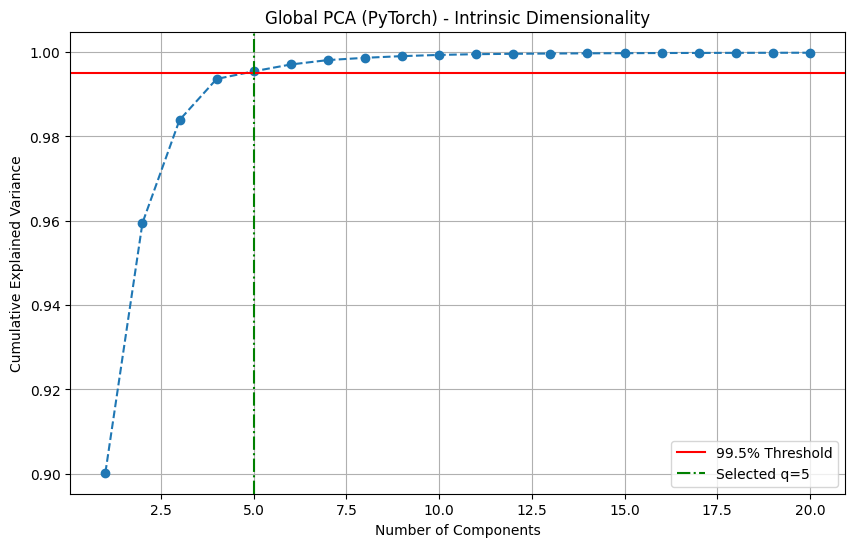

In [6]:
# 1. Mean Centering
mean_vector = data.mean(dim=0)
X_centered = data - mean_vector

# 2. Compute Covariance Matrix
n_samples = X_centered.shape[0]
cov_matrix = (X_centered.T @ X_centered) / (n_samples - 1)

# 3. Eigendecomposition (PCA)
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

# 4. Sort indices in descending order (eigh returns ascending)
sorted_indices = torch.argsort(eigenvalues, descending=True)
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_components = eigenvectors[:, sorted_indices]

# 5. Calculate Cumulative Variance
total_variance = sorted_eigenvalues.sum()
explained_variance_ratio = sorted_eigenvalues / total_variance
cum_var = torch.cumsum(explained_variance_ratio, dim=0)

# 6. Find the threshold (99.5%)
threshold = 0.995
n_components_995 = (cum_var >= threshold).nonzero(as_tuple=False)[0].item() + 1

print("-" * 30)
print(f"Cumulative Variance for top 10 components:\n {cum_var[:10]}")
print("-" * 30)
print(f"Number of components to explain {threshold*100}% variance: {n_components_995}")
print(f"Ceiling for q (latent factors) set to: {n_components_995}")

# 7. Save the PCA Model
pca_state = {
    'components': sorted_components[:, :n_components_995], # Save only needed components
    'mean': mean_vector,
    'explained_variance': sorted_eigenvalues[:n_components_995],
    'n_components_995': n_components_995
}

if ADD_SPATIAL_INFO:
    spatial_str = "spatial"
else:
    spatial_str = "no_spatial"

torch.save(pca_state, f'models/{spatial_str}/pca_benchmark_{data_product}.pt')
print(f"PCA model saved to 'models/{spatial_str}/pca_benchmark_{data_product}.pt'")

# 8. Visual Check
# Move to CPU for plotting
cum_var_np = cum_var.cpu().numpy()
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), cum_var_np[:20], marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-', label=f'{threshold*100}% Threshold')
plt.axvline(x=n_components_995, color='g', linestyle='-.', label=f'Selected q={n_components_995}')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Global PCA (PyTorch) - Intrinsic Dimensionality')
plt.legend()
plt.grid(True)
plt.show()

### 2. Subsample the dataset

In [ ]:
# Configuration
N_SUBSET = 50000 
torch.manual_seed(42)

# Generate random indices
if data.shape[0] > N_SUBSET:
    # random_split or randperm is standard torch practice
    indices = torch.randperm(data.shape[0])[:N_SUBSET]
    data_subset = data[indices]
    print(f"Subsampled data from {data.shape[0]} to {data_subset.shape[0]} samples.")
else:
    print("Dataset smaller than requested subset. Using full data.")
    data_subset = data

print(f"Subset shape: {data_subset.shape}")

### 3. Perform BIC grid search
Notable fix: We scale the data between 0 and 1. The reason for this is that the large values cause the calculation of the variance to explode.

## Perform Log-Likelyhood Grid Search

We hold out 10% of the training-samples, and train the MFA on the remainding 90%. For each batch, we calculate the out-of-sample log-likelyhood of the model explaining the pixels. 

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from MFA import MFA # Ensure your updated MFA class with heteroscedastic noise is used

torch.manual_seed(42)

# Grid Configuration
k_range = range(2, 10, 2)
q_ceiling = 6 # Adjust based on your needs
q_range = range(2, q_ceiling + 1) 

# 1. Train/Test Split
train_size = int(0.8 * len(data_subset))
test_size = len(data_subset) - train_size
X_train_dataset, X_test_dataset = torch.utils.data.random_split(data_subset, [train_size, test_size])

X_train = data_subset[X_train_dataset.indices].float()
X_test = data_subset[X_test_dataset.indices].float()

print(f"Starting L2-Normalized Log-Likelihood Grid Search.")
print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples.")

# 2. STATELESS PREPROCESSING: L2 Normalization (No mean centering!)
X_train_processed = F.normalize(X_train, p=2, dim=1)
X_test_processed = F.normalize(X_test, p=2, dim=1)

print(f"Sanity Check - Train Norms: {torch.linalg.norm(X_train_processed[:3], dim=1)}")

# 3. The Grid Search Loop
results_list = []
i = 1
total_iters = len(k_range) * len(q_range)

for k in k_range:
    for q in q_range:
        try: 
            model = MFA(n_components=k, n_features=X_train_processed.shape[1], n_factors=q, device=device)
            
            # Initialize and FIT ONLY ON TRAIN DATA
            model.initialize_parameters(X_train_processed)
            model.fit(X_train_processed)

            # CALCULATE OUT-OF-SAMPLE LOG-LIKELIHOOD
            with torch.no_grad():
                _, log_likelihood_per_pixel = model.e_step(X_test_processed)
                out_of_sample_ll = log_likelihood_per_pixel.mean().item()
    
            results_list.append({'K': k, 'q': q, 'Test_Log_Likelihood': out_of_sample_ll})
            print(f"Completed {i}/{total_iters} - K={k}, q={q}, Test LL={out_of_sample_ll:.4f}")

            if device.type == 'cuda': torch.cuda.empty_cache()
        except Exception as e:
            print(f"Failed for K={k}, q={q}: {e}")
        i += 1

# 4. Visualization
results_df = pd.DataFrame(results_list)
best_row = results_df.loc[results_df['Test_Log_Likelihood'].idxmax()]
print("-" * 30)
print(f"Best Model configuration: K={int(best_row['K'])}, q={int(best_row['q'])}")
print("-" * 30)

ll_pivot = results_df.pivot(index="K", columns="q", values="Test_Log_Likelihood")
plt.figure(figsize=(10, 8)) 
sns.heatmap(ll_pivot, annot=True, fmt=".2f", cmap="viridis") 
plt.title("Out-of-Sample Log-Likelihood (L2 Normalized Manifold)")
plt.xlabel("Latent Factors (q)")
plt.ylabel("Mixture Components (K)")
plt.show()

K_optimal = int(best_row['K'])
q_optimal = int(best_row['q'])

### Retrain the model on the complete dataset 

In [11]:
# 1. Prepare entire dataset with L2 Normalization
data_tensor = torch.tensor(data, dtype=torch.float32, device=device)
X_final_processed = F.normalize(data_tensor, p=2, dim=1)

K_optimal = 6
q_optimal = 3

print(f"Training final MFA model on {X_final_processed.shape[0]} samples...")

# 2. Train final model
final_model = MFA(n_components=K_optimal, n_features=X_final_processed.shape[1], n_factors=q_optimal, device=device)
final_model.initialize_parameters(X_final_processed)
final_model.fit(X_final_processed)

# 3. Save model state
mfa_state = {
    'model_state_dict': final_model.state_dict(),
    'hyperparameters': {
        'n_components': K_optimal,
        'n_features': X_final_processed.shape[1],
        'n_factors': q_optimal
    },
    'preprocessing': {
        'method': 'L2_norm' # We no longer save global max or mean!
    }
}

save_path = f'models/mfa_L2_k{K_optimal}_q{q_optimal}.pt'
torch.save(mfa_state, save_path)
print(f"Final L2 Model saved to {save_path}")

C:\Users\trygvemt\AppData\Local\Temp\ipykernel_10900\3398996074.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data, dtype=torch.float32, device=device)


Training final MFA model on 199980 samples...
Final L2 Model saved to models/mfa_L2_k6_q3.pt
